# What are sparse models looking at?

This notebook provides visualizations of ResNet50 models pay attention to when they classify.  In other words, what are the models looking at.  This information can be used for localization, but here it is provided merely to build our intuition.  

We use a technique from [Zhou et. al](http://cnnlocalization.csail.mit.edu/) and apply it ResNet50, building on [Alexis Cook's Keras work](https://alexisbcook.github.io/2017/global-average-pooling-layers-for-object-localization/), we levarge the global average pooling layer that exists in ResNet50.

We apply this technique to a pre-trained ResNet50 model from TorchVision (referred to as "dense" in the code), and to two sparse ResNet50 models trained using Distiller.  One sparse model, that we call "sparse-fc" is fully dense except for the last layer, which is 93% sparse.  It scores a top1 validation accuracy of 76.45 vs. the pretrained dense baseline which has a top1 score of [76.15](https://pytorch.org/docs/stable/torchvision/models.html).
The second sparse model is 70.7% (the total sparsity of the entire model), and scores a Top1 validation accuracy of 76.09.

What do these three different networks pay attention to?  Scroll down and give it a try.

Unfortunately, the sparse ResNet50 models are not currently available for download from our AWS directory.  You can place the code referring to these models in remark and look at the results for dense ResNet50.

See:
* B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).
* https://alexisbcook.github.io/2017/global-average-pooling-layers-for-object-localization/

In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable
import scipy.stats as ss

# Relative import of code from distiller, w/o installing the package
import os
import sys
import numpy as np
import scipy   
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import distiller
import distiller.apputils as apputils
import distiller.models as models
from distiller.apputils import *

plt.style.use('seaborn') # pretty matplotlib plots

## Utilities

In [2]:
def imagenet_load_data(data_dir, batch_size, num_workers, shuffle=True):
    """Load the ImageNet dataset"""
    test_dir = os.path.join(data_dir, 'val')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    test_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(test_dir, transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=True)

    return test_loader

In [3]:
BATCH_SIZE = 4

# Data loader
test_loader = imagenet_load_data("../../data.imagenet/", 
                                 batch_size=BATCH_SIZE, 
                                 num_workers=2)
    
    
# Reverse the normalization transformations we performed when we loaded the data 
# for consumption by our CNN.
# See: https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/3
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

def process_imagenet_img(img, remove_imagenet_normalization = True):
    if remove_imagenet_normalization:
        img = img.clone()
        img = invTrans(img)
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

# Load a dictionary of {<class_id>: <class_description>}
# Source: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a#file-imagenet1000_clsid_to_human-txt
from imagenet_classes import imagenet_classes

### Sample some images from the dataset

dugong, Dugong dugon
ski mask
Maltese dog, Maltese terrier, Maltese
bald eagle, American eagle, Haliaeetus leucocephalus


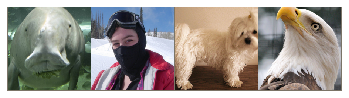

In [4]:
# Randomly sample the training images dataset and display some images.
# We will use these images later, but for now we just want to take a quick look at them.
dataiter = iter(test_loader)
images, labels = dataiter.next()

# remove the grid
plt.grid(True)
plt.xticks([])
plt.yticks([])
plt.imshow(process_imagenet_img(torchvision.utils.make_grid(images)))
true_class_names = [imagenet_classes[labels[j].item()] for j in range(BATCH_SIZE)]
print('\n'.join('%s' % class_name for class_name in true_class_names))

## Load ResNet 50

In [5]:
# Load the various models
_models = {}
_models["dense"] = models.create_model(pretrained=True, dataset='imagenet', arch='resnet50', parallel=False)

# Load the FC-sparse compressed model 
_models["fc-sparse"] = models.create_model(pretrained=True, dataset='imagenet', arch='resnet50', parallel=True)
load_checkpoint(_models["fc-sparse"] , "../examples/classifier_compression/resnet50_checkpoint_93_fc-sparse_76.45-top1.pth.tar");
_models["fc-sparse"]  = distiller.make_non_parallel_copy(_models["fc-sparse"] )

# Load the "sparse" compressed model 
_models["sparse"] = models.create_model(pretrained=True, dataset='imagenet', arch='resnet50', parallel=True)
load_checkpoint(_models["sparse"] , "../examples/classifier_compression/resnet50_checkpoint_70.66-sparse_76.09-top1.pth.tar");
_models["sparse"]  = distiller.make_non_parallel_copy(_models["sparse"] )


### Run a small batch of predictions

In [6]:
# Get predictions for the images we sampled from the dataset
from collections import namedtuple
Prediction = namedtuple('Prediction', 'scores classids')

def get_predictions(model_type):
    model = _models[model_type]
    model.eval()
    predictions = model(images.cuda())

    top1_vals, top1_indices = torch.max(predictions, 1)
    print(predictions.shape)
    #top5_vals, top5_indices = torch.max(predictions, 5)
    predicted_class_names = [imagenet_classes[top1_indices[j].item()] for j in range(BATCH_SIZE)]

    # Print inference results
    print("Model: %s" % model_type)
    print('\n'.join('\t%s' % predicted_class_name for predicted_class_name in predicted_class_names)) 
    print()
    return predictions, top1_indices, predicted_class_names

predictions = {}
top1_indices = {}
predicted_class_names = {}
for model_type in ["dense", "sparse", "fc-sparse"]:
    predictions[model_type], top1_indices[model_type], predicted_class_names[model_type] = \
            get_predictions(model_type)

torch.Size([4, 1000])
Model: dense
	dugong, Dugong dugon
	ski mask
	Maltese dog, Maltese terrier, Maltese
	bald eagle, American eagle, Haliaeetus leucocephalus

torch.Size([4, 1000])
Model: sparse
	dugong, Dugong dugon
	ski mask
	Maltese dog, Maltese terrier, Maltese
	bald eagle, American eagle, Haliaeetus leucocephalus

torch.Size([4, 1000])
Model: fc-sparse
	dugong, Dugong dugon
	ski mask
	Maltese dog, Maltese terrier, Maltese
	bald eagle, American eagle, Haliaeetus leucocephalus



## Copy the activations of the last convolution

We register to the forward-hook of the last convolutional layer and copy the activations it produces.
Because we run a forward batch of images, we also copy a batch of activations.

These activations have the shape: BATCH_SIZE x 2048 x 7 x 7
In other words, there BATCH_SIZE activations, each with 2048 channels. 
Each channel has spatial dimensions 7x7.

In [7]:
from functools import partial

def get_last_conv_feature_maps(model, model_type):
    def save_conv_output(m, i, o):
        m.cached_feature_maps = o

    fc_weights = model.state_dict()['fc.weight']
    fc_layer = model.fc
    avgpool_layer = model.avgpool   
    last_conv = model.layer4[2].relu3
    
    cb_handle = last_conv.register_forward_hook(save_conv_output)
    h_x = model(images.cuda())
    cb_handle.remove()    
    return last_conv.cached_feature_maps

last_conv_output = {}
for model_type in ["dense", "sparse", "fc-sparse"]:
    print(model_type)
    last_conv_output[model_type] = get_last_conv_feature_maps(_models[model_type], model_type)
    last_conv_output[model_type] = last_conv_output[model_type].detach().cpu().numpy()

dense
sparse
fc-sparse


## Generate class activation maps (CAMs)

In [8]:
# Produce the class activation map for object class that is predicted to be in the image

def get_CAMs(model_type):
    CAMs = []
    model = _models[model_type]
    
    for i, prediction in enumerate(top1_indices[model_type]):
        # bilinear upsampling to resize each filtered image to size of original image 
        fc_weights = model.state_dict()['fc.weight']
        mat_for_mult2 = scipy.ndimage.zoom(last_conv_output[model_type][i], (1, 32, 32), order=1) # dim: 224 x 224 x 2048

        predicted_class = predictions[model_type]
        CAMs.append(torch.matmul(torch.tensor(mat_for_mult2.reshape(2048, 224*224)).t().cuda(), 
                                 fc_weights[prediction].cuda()).cpu())
    return CAMs
        
CAMs = {}
for model_type in ["dense", "sparse", "fc-sparse"]:
    print("Computing %s CAMs..." % model_type)
    CAMs[model_type] = get_CAMs(model_type)
print("Done.")

Computing dense CAMs...
Computing sparse CAMs...
Computing fc-sparse CAMs...
Done.


### Display overlays of the CAMs

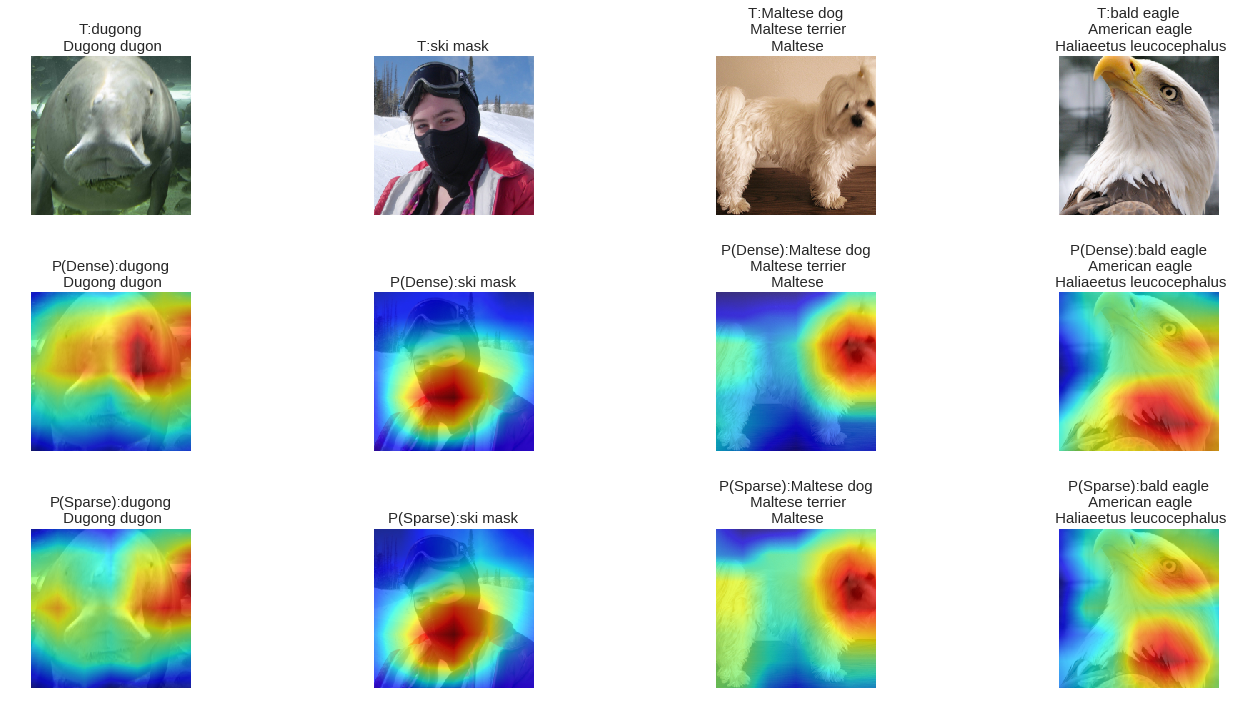

In [9]:
def format_title(title):
    return '\n'.join(title.split(','))

plt.figure(figsize=(20, 10))
fontsize=15
for i in range(BATCH_SIZE):
    plt.subplot(3,4,i+1)
    plt.title("T:" + format_title(true_class_names[i]), fontsize=fontsize)
    plt.axis("off")
    plt.grid(False)
    plt.imshow(process_imagenet_img(images[i]))
    
    plt.subplot(3,4,4+i+1)
    predicted_class_name = predicted_class_names["dense"][i]
    plt.title("P(Dense):" + format_title(predicted_class_name), fontsize=fontsize)
    plt.axis("off")
    plt.grid(False)
    plt.imshow(process_imagenet_img(images[i]))
    plt.imshow(CAMs["dense"][i].reshape(224,224), cmap='jet', alpha=0.7)
    
    plt.subplot(3,4,8+i+1)
    predicted_class_name = predicted_class_names["sparse"][i]
    plt.title("P(Sparse):" + format_title(predicted_class_name), fontsize=fontsize)
    plt.axis("off")
    plt.grid(False)
    plt.imshow(process_imagenet_img(images[i]))
    plt.imshow(CAMs["sparse"][i].reshape(224,224), cmap='jet', alpha=0.7)
    
plt.tight_layout()